# Setup

In [1]:
import os
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## 1. Reference Trajectory

In [2]:
def random_shape(t):
    x = 6 * np.sin(t/3)
    y = -6 * np.sin(t/3) * np.cos(t/3)
    z = 6 * np.cos(t/3)

    ref_traj = np.array([x,y,z])
    return ref_traj

## 2. Display my dataset structure

In [3]:
data_disp = pd.read_csv("Data2\State_Control_Statedot_60sec_0_0_0.csv")
data_disp.head()

,time,x,y,z,roll,pitch,yaw,xdot,ydot,zdot,...,_zdot,_p,_q,_r,_xddot,_yddot,_zddot,_phiddot,_thetaddtot,_yawddot
0,0.0,0.018420,0.018420,0.018420,0.018420,0.018420,0.018420,0.018420,0.018420,0.018420,...,0.018420,0.018420,0.018420,0.018420,-0.329738,0.317863,7.768647,-0.115811,-0.105081,-0.073399
1,0.1,0.020366,0.020366,0.020366,0.020545,0.020165,0.020351,-0.079783,0.115592,4.285636,...,4.285636,-0.053938,-0.047723,-0.030463,-0.230646,0.225669,1.396440,-0.076989,-0.065794,0.020474
2,0.2,-0.033924,0.053714,1.973963,-0.022402,-0.019281,-0.011467,-0.060801,0.063664,1.160897,...,1.160897,-0.047315,-0.039826,0.008758,0.258785,-0.307815,3.792186,0.060279,0.037721,0.005400
3,0.3,-0.021895,0.042654,0.799018,-0.017225,-0.013395,0.009928,0.006735,0.003912,2.554847,...,2.554847,0.029197,0.017612,0.005870,0.175337,-0.220927,3.114277,-0.130212,-0.115722,-0.031387
4,0.4,-0.017878,-0.002573,1.489851,-0.004727,-0.009296,-0.010660,-0.022394,-0.035368,2.352421,...,2.352421,-0.089235,-0.081342,-0.030652,0.113329,-0.059156,2.447403,0.023909,-0.004860,0.082615


## 3. Display Trajectory

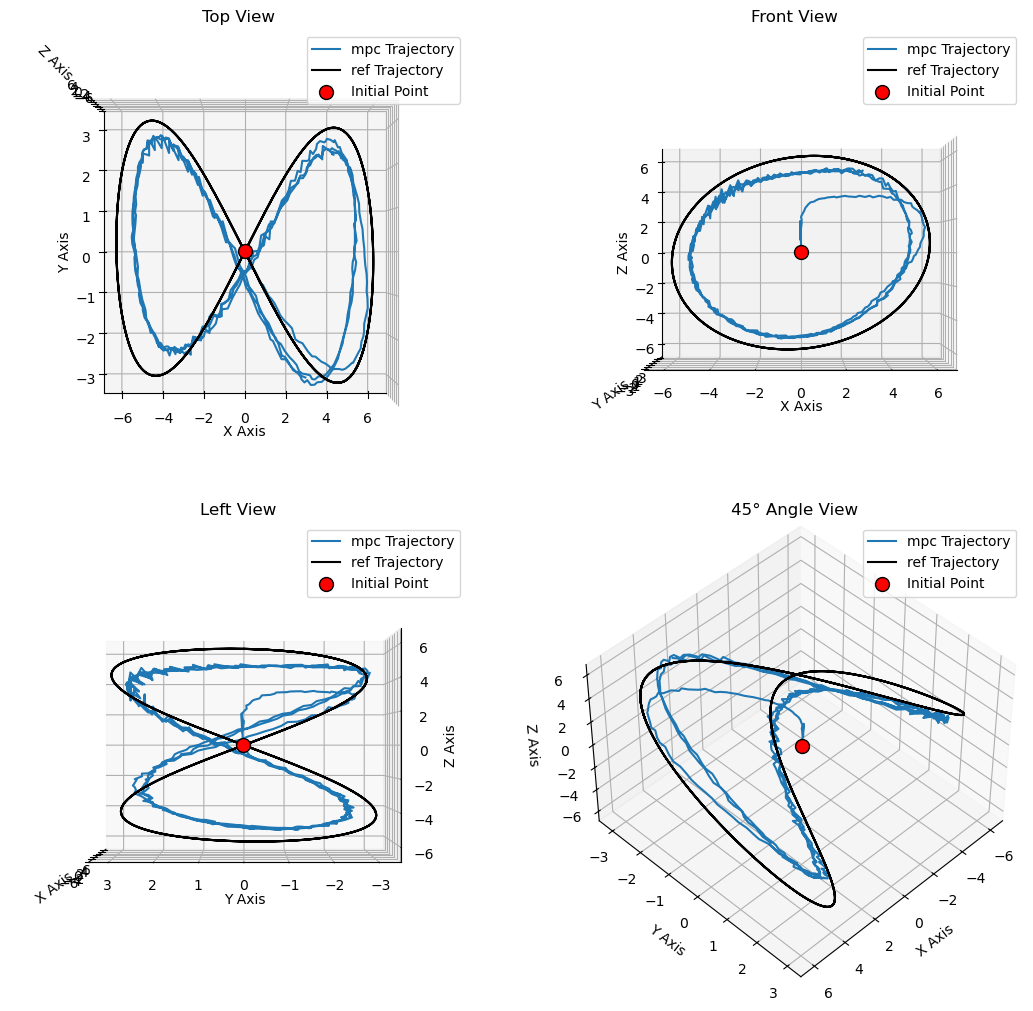

In [4]:
date_time = data_disp['time']
ref_traj = random_shape(date_time)
ref_x = ref_traj[0,:]
ref_y = ref_traj[1,:]
ref_z = ref_traj[2,:]

x = data_disp['x'][:]
y = data_disp['y'][:]
z = data_disp['z'][:]

views = [
    {"elev": 90, "azim": -90, "title": "Top View"},  
    {"elev": 0, "azim": -90, "title": "Front View"},   
    {"elev": 0, "azim": 180, "title": "Left View"},    
    {"elev": 45, "azim": 45, "title": "45° Angle View"}  
]

fig = plt.figure(figsize=(12, 10))

for i, view in enumerate(views, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')  # 2x2 grid of subplots

    # Plot trajectories
    ax.plot(x, y, z, label='mpc Trajectory')
    ax.plot(ref_x, ref_y, ref_z, label='ref Trajectory', color='black')

    # Plot initial point
    ax.scatter(x.iloc[0], y.iloc[0], z.iloc[0], color='red', s=100, label='Initial Point', edgecolor='k')

    # Set labels and title for each subplot
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title(view["title"])
    ax.view_init(elev=view["elev"], azim=view["azim"])

    ax.legend()

# Show the plot with multiple angles
plt.tight_layout()
plt.show()

# Load Dataset

In [5]:
data_folder = 'Data2'
data = {}

csv_files = [f for f in os.listdir(data_folder) if re.match(r'State_Control_Statedot_60sec_\d+_\d+_\d+\.csv', f)]

all_state_control = []
all_statedot = []

for file_name in csv_files:
    # Extract initial conditions from the filename
    tokens = re.findall(r'_(\d+)_(\d+)_(\d+)\.csv$', file_name)
    if tokens:
        initial_condition = tokens[0]
        initial_str = f'init_{initial_condition[0]}_{initial_condition[1]}_{initial_condition[2]}'

        # Read the CSV file
        full_path = os.path.join(data_folder, file_name)
        csv_data = pd.read_csv(full_path)

        time = csv_data.iloc[:, 0].values
        state_control = csv_data.iloc[:, 1:17].values
        statedot = csv_data.iloc[:, 17:29].values

        # Save to dictionary with initial conditions as key
        data[initial_str] = {'time': time, 'state_control': state_control, 'statedot': statedot}

        all_state_control.append(state_control)
        all_statedot.append(statedot)

# Normalization

In [6]:
all_state_control = np.concatenate(all_state_control, axis=0)
all_statedot = np.concatenate(all_statedot, axis=0)

xu_mean = np.mean(all_state_control, axis=0)
xu_std = np.std(all_state_control, axis=0)
xdot_mean = np.mean(all_statedot, axis=0)
xdot_std = np.std(all_statedot, axis=0)

# Norm in all dataset
data_normalized = {}
for key in data.keys():
    xu = data[key]['state_control']
    xdot = data[key]['statedot']

    xu_normalized = (state_control - xu_mean) / xu_std
    xdot_normalized = (statedot - xdot_mean) / xdot_std

    data_normalized[key] = {'time': data[key]['time'], 'state_control': xu_normalized, 'statedot': xdot_normalized}

# Partition

In [7]:
# total_files = len(data)
total_files = len(data_normalized)
print(total_files)

26


In [8]:
train_percent = 0.8
val_percent = 0.1

train_count = int(train_percent * total_files)
val_count = int(val_percent * total_files)
test_count = total_files - train_count - val_count

# Randomize order of senario
keys = list(data_normalized.keys())
np.random.shuffle(keys)

train_keys = keys[:train_count]
val_keys = keys[train_count:train_count + val_count]
test_keys = keys[train_count + val_count:]


# Initialize new dictionaries to store the partitioned data
train_data = {key: data_normalized[key] for key in train_keys}
val_data = {key: data_normalized[key] for key in val_keys}
test_data = {key: data_normalized[key] for key in test_keys}

print(f'Total data: {total_files} sets.\nTraining data: {train_count} sets.\nValidation data: {val_count} sets.\nTesting data: {test_count} sets.')

Total data: 26 sets.
Training data: 20 sets.
Validation data: 2 sets.
Testing data: 4 sets.


In [9]:
for key, value in test_data.items():
    print(f"Key: {key}, Time shape: {value['time'].shape}, State_Control shape: {value['state_control'].shape}, xdot shape: {value['statedot'].shape}")

Key: init_2_2_0, Time shape: (601,), State_Control shape: (601, 16), xdot shape: (601, 12)
Key: init_3_2_0, Time shape: (601,), State_Control shape: (601, 16), xdot shape: (601, 12)
Key: init_0_0_0, Time shape: (601,), State_Control shape: (601, 16), xdot shape: (601, 12)
Key: init_5_2_0, Time shape: (601,), State_Control shape: (601, 16), xdot shape: (601, 12)


# Sliding Window

In [10]:
class Window(Dataset):
    def __init__(self, time_data, xu_data, xdot_data, input_width, prediction_width, predict_columns=None):
        
        # Store the raw data.
        self.time_data = time_data
        self.xu_data = xu_data
        self.xdot_data = xdot_data

        # Store the sequence length
        self.input_width = input_width
        self.prediction_width = prediction_width

        # Work out the label column indices.
        self.predict_columns = predict_columns
        if predict_columns is not None:
            # If the data is a DataFrame, convert column names to indices
            if isinstance(xdot_data, pd.DataFrame):
                self.label_columns_indices = [xdot_data.columns.get_loc(col) for col in predict_columns]
            else:
                # If it's a NumPy array, assume columns are already represented by integer indices
                self.label_columns_indices = predict_columns

        # Calculate the number of valid input-output pairs
        self.num_samples = len(xu_data) - input_width - prediction_width + 1

        self.split_window()

    def split_window(self):
        # Precompute the inputs and targets
        self.inputs_time = []
        self.targets_time = []
        self.inputs = []
        self.targets = []

        for i in range(self.num_samples):
            # Time 
            input_time_sequence = self.time_data[i:i + self.input_width]
            target_time_control = self.time_data[i + self.input_width:i + self.input_width + self.prediction_width]

            # Input: the sequence of state data
            input_sequence = self.xu_data[i:i + self.input_width]
            
            # Target: the next predict time steps of control data
            target_control = self.xdot_data[i + self.input_width:i + self.input_width + self.prediction_width]

            self.inputs_time.append(input_time_sequence)
            self.targets_time.append(target_time_control)
            self.inputs.append(input_sequence)
            self.targets.append(target_control)
        # return self.inputs, self.targets, self.inputs_time, self.targets_time

    def __repr__(self):
        self.total_window_size = self.input_width + self.prediction_width

        self.input_slice = slice(0, self.input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.predict_start = self.total_window_size - self.prediction_width
        self.predict_slice = slice(self.predict_start, None)
        self.predict_indices = np.arange(self.total_window_size)[self.predict_slice]
        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Predict indices: {self.predict_indices}',
            f'Label column name(s): {self.predict_columns}'])
    
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_time': torch.tensor(self.inputs_time[idx], dtype=torch.float32),
            'input': torch.tensor(self.inputs[idx], dtype=torch.float32),
            'target_time': torch.tensor(self.targets_time[idx], dtype=torch.float32),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

## 1. Pick 1 dataset to set visualizaiton

In [11]:
example_key = train_keys[0]
time_data = train_data[example_key]['time']
xu_data = train_data[example_key]['state_control']
xdot_data = train_data[example_key]['statedot']

w1 = Window(time_data=time_data,xu_data=xu_data,xdot_data=xdot_data,
            input_width=1, prediction_width=1,
            predict_columns=['_xdot','_ydot','_zdot','_p','_q','_r','_xddot','_yddot','_zddot','_phiddot','_thetaddtot','_yawddot']) 
# _xdot,_ydot,_zdot,_p,_q,_r,_xddot,_yddot,_zddot,_phiddot,_thetaddtot,_yawddot
w1

Total window size: 2
Input indices: [0]
Predict indices: [1]
Label column name(s): ['_xdot', '_ydot', '_zdot', '_p', '_q', '_r', '_xddot', '_yddot', '_zddot', '_phiddot', '_thetaddtot', '_yawddot']

In [12]:
# Check the total number of samples in the window
print(f"Total samples: {len(w1)}")

Total samples: 600


In [13]:
for i in range(3): 
    sample = w1[i]
    print(f"\nSample {i}:")
    print("Input Time:", sample['input_time'])
    print("Input Data:", sample['input'])
    print("Target Time:", sample['target_time'])
    print("Target Data:", sample['target'])



Sample 0:
Input Time: tensor([0.])
Input Data: tensor([[ 1.3410,  2.7343, -0.0362,  0.1100,  0.2553,  0.5609,  0.0092,  0.0706,
         -0.0592,  0.0606,  0.1526,  0.3255,  7.0908, -2.2590,  3.3331, -0.7989]])
Target Time: tensor([0.1000])
Target Data: tensor([[-0.0531,  0.1329,  2.5196, -2.0288,  3.2718, -0.6266, -0.3174,  0.1579,
          0.7904, -0.2201, -0.2775,  0.1631]])

Sample 1:
Input Time: tensor([0.1000])
Input Data: tensor([[ 0.7923,  1.6462, -0.0357,  0.1166,  0.2632,  0.5527, -0.0531,  0.1330,
          2.5246, -2.0316,  3.2779, -0.6272,  0.6946, -0.2193, -0.2780,  0.1624]])
Target Time: tensor([0.2000])
Target Data: tensor([[-0.0326,  0.0938,  0.4556, -0.3645,  0.0860,  0.1343, -2.9559, -1.8977,
          2.3359,  0.0242,  0.0394,  0.1646]])

Sample 2:
Input Time: tensor([0.2000])
Input Data: tensor([[ 0.8665,  1.8474,  0.6030, -1.3981,  2.1183, -0.5852, -0.0326,  0.0938,
          0.4576, -0.3659,  0.0872,  0.1339,  2.6720,  0.0247,  0.0381,  0.1636]])
Target Time: t

In [14]:
# Create the DataLoader with batch size of 32
loader = DataLoader(w1, batch_size=30, shuffle=False)

# Get the first batch from the DataLoader
for batch in loader:
    print("Batch:")
    print("Input Time:", batch['input_time'].shape)    # (32, input_width)
    print("Input Data:", batch['input'].shape)         # (32, input_width, feature dimension)
    print("Target Time:", batch['target_time'].shape)  # (32, prediction_width)
    print("Target Data:", batch['target'].shape)       # (32, prediction_width, feature dimension)
    break  # Exit after the first batch

Batch:
Input Time: torch.Size([30, 1])
Input Data: torch.Size([30, 1, 16])
Target Time: torch.Size([30, 1])
Target Data: torch.Size([30, 1, 12])


In [15]:
total_batches = len(loader)
print(f"Total number of batches: {total_batches}")

Total number of batches: 20


# Combin all data to pair and batch

In [16]:
batch_size = 30
input_width = 1
# Create data loaders for training scenarios
train_loaders = []
for key in train_data.keys():
    time_data = train_data[key]['time']
    xu_data = train_data[key]['state_control']
    xdot_data = train_data[key]['statedot']
    scenario_dataset = Window(time_data=time_data,xu_data=xu_data,xdot_data=xdot_data,
                                input_width=input_width, prediction_width=1,
                                predict_columns=['_xdot','_ydot','_zdot','_p','_q','_r','_xddot','_yddot','_zddot','_phiddot','_thetaddtot','_yawddot']) 
# _xdot,_ydot,_zdot,_p,_q,_r,_xddot,_yddot,_zddot,_phiddot,_thetaddtot,_yawddot
    scenario_loader = DataLoader(scenario_dataset, batch_size=batch_size, shuffle=False)
    train_loaders.append(scenario_loader)

In [17]:
print(f"Number of DataLoaders: {len(train_loaders)}")


Number of DataLoaders: 20


In [18]:
for i, loader in enumerate(train_loaders, start=1):
    num_batches = len(loader)
    print(f"DataLoader {i}: {num_batches} batches")

DataLoader 1: 20 batches
DataLoader 2: 20 batches
DataLoader 3: 20 batches
DataLoader 4: 20 batches
DataLoader 5: 20 batches
DataLoader 6: 20 batches
DataLoader 7: 20 batches
DataLoader 8: 20 batches
DataLoader 9: 20 batches
DataLoader 10: 20 batches
DataLoader 11: 20 batches
DataLoader 12: 20 batches
DataLoader 13: 20 batches
DataLoader 14: 20 batches
DataLoader 15: 20 batches
DataLoader 16: 20 batches
DataLoader 17: 20 batches
DataLoader 18: 20 batches
DataLoader 19: 20 batches
DataLoader 20: 20 batches


In [19]:
val_loaders = []
for key in val_data.keys():
    time_data = val_data[key]['time']
    xu_data = val_data[key]['state_control']
    xdot_data = val_data[key]['statedot']
    scenario_dataset = Window(time_data=time_data,xu_data=xu_data,xdot_data=xdot_data,
                                input_width=input_width, prediction_width=1,
                                predict_columns=['_xdot','_ydot','_zdot','_p','_q','_r','_xddot','_yddot','_zddot','_phiddot','_thetaddtot','_yawddot']) 
# _xdot,_ydot,_zdot,_p,_q,_r,_xddot,_yddot,_zddot,_phiddot,_thetaddtot,_yawddot
    scenario_loader = DataLoader(scenario_dataset, batch_size=batch_size, shuffle=False)
    val_loaders.append(scenario_loader)

test_loaders = []
for key in test_data.keys():
    time_data = test_data[key]['time']
    xu_data = test_data[key]['state_control']
    xdot_data = test_data[key]['statedot']
    scenario_dataset = Window(time_data=time_data,xu_data=xu_data,xdot_data=xdot_data,
                                input_width=input_width, prediction_width=1,
                                predict_columns=['_xdot','_ydot','_zdot','_p','_q','_r','_xddot','_yddot','_zddot','_phiddot','_thetaddtot','_yawddot']) 
# _xdot,_ydot,_zdot,_p,_q,_r,_xddot,_yddot,_zddot,_phiddot,_thetaddtot,_yawddot
    scenario_loader = DataLoader(scenario_dataset, batch_size=batch_size, shuffle=False)
    test_loaders.append(scenario_loader)

# Check if GPU is avaliable

In [20]:
print(torch.cuda.is_available())

True


# Define Model

## 1. Simple Network

In [21]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=16, hidden_size=64, output_size=12, num_layers=2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out) 
        # # Use only the last time step
        # out = self.fc(out[:, -1, :])
        return out

## 2. PI-TCN’s architecture

In [22]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super(TCNBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=1, padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
    
class TCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, num_layers=4, dropout=0.1):
        super(TCN, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(TCNBlock(input_dim if _ == 0 else hidden_dim, hidden_dim, dropout=dropout))
        self.tcn = nn.Sequential(*layers)

    def forward(self, x):
        return self.tcn(x)
    
class MLP(nn.Module):
    def __init__(self, input_dim=16, hidden_dims=[64, 32, 32], output_dim=12):
        super(MLP, self).__init__()
        layers = []
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dims[i - 1], hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)
    
class PI_TCN(nn.Module):
    def __init__(self, tcn_input_dim=16, mlp_output_dim=12):
        super(PI_TCN, self).__init__()
        self.tcn = TCN(input_dim=tcn_input_dim, hidden_dim=16, num_layers=4, dropout=0.1)
        self.mlp = MLP(input_dim=16, hidden_dims=[64, 32, 32], output_dim=mlp_output_dim)

    def forward(self, x):
        x = self.tcn(x)
        x = x[:, :, -1]  # Take the last time step's output from TCN
        return self.mlp(x)
    

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_RNN = SimpleRNN().to(device)
model_PITCN = PI_TCN().to(device)
print(f'Using device: {device}')

Using device: cuda


# Tensorboard setup

In [24]:
output_folder = 'Training_output_sysID'
# TensorBoard setup
writer_RNN = SummaryWriter(log_dir=os.path.join(output_folder, 'tensorboard_LSTM_logs100_lr301'))
writer_PITCH = SummaryWriter(log_dir=os.path.join(output_folder, 'tensorboard_PITCH_logs100_lr301'))

# Train simple model

In [25]:
criterion_RNN = nn.MSELoss()
optimizer_RNN = optim.Adam(model_RNN.parameters(), lr=0.0001)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model_RNN.train()
    epoch_loss = 0.0
    total_samples = 0

    for scenario_loader in train_loaders:  # Iterate through each scenario-specific loader
        for batch in scenario_loader:
            input_sequence = batch['input'].to(device)  # Shape: (batch_size, seq_length, input_size)
            ouput_target = batch['target'].to(device)  # Shape: (batch_size, output_size)


            # Forward pass
            xdot_pred = model_RNN(input_sequence)

            # Compute loss
            loss = criterion_RNN(xdot_pred, ouput_target)

            # Backward pass and optimization
            optimizer_RNN.zero_grad()
            loss.backward()
            optimizer_RNN.step()

            # Accumulate loss
            epoch_loss += loss.item() * input_sequence.size(0)
            total_samples += input_sequence.size(0)
    
    # Calculate and print average loss for the epoch
    avg_loss = epoch_loss / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    writer_RNN.add_scalar('Training Loss', avg_loss, epoch)

    # Validation Phase
    model_RNN.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0  # Total accumulated validation loss
    total_val_samples = 0  # Total number of validation samples

    with torch.no_grad():  # Disable gradient calculations
        for val_loader in val_loaders:
            for batch in val_loader:
                input_sequence = batch['input'].to(device)  # Shape: (batch_size, seq_length, input_size)
                ouput_target = batch['target'].to(device)  # Shape: (batch_size, output_size)

                # Forward pass
                xdot_pred = model_RNN(input_sequence)

                # Compute loss
                loss = criterion_RNN(xdot_pred, ouput_target)

                # Accumulate validation loss and total samples
                total_val_loss += loss.item() * input_sequence.size(0)
                total_val_samples += input_sequence.size(0)

    # Compute the average validation loss for the epoch
    avg_val_loss = total_val_loss / total_val_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')
    writer_RNN.add_scalar('Validation Loss', avg_val_loss, epoch)

# Save the trained model
model_save_path = os.path.join(output_folder, 'trained_RNN_model_100.pth')
torch.save(model_RNN.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

print("Training finished!")
writer_RNN.close()

Epoch [1/100], Loss: 0.9994
Epoch [1/100], Validation Loss: 0.9593
Epoch [2/100], Loss: 0.8481
Epoch [2/100], Validation Loss: 0.7102
Epoch [3/100], Loss: 0.5898
Epoch [3/100], Validation Loss: 0.4854
Epoch [4/100], Loss: 0.4106
Epoch [4/100], Validation Loss: 0.3472
Epoch [5/100], Loss: 0.3042
Epoch [5/100], Validation Loss: 0.2688
Epoch [6/100], Loss: 0.2436
Epoch [6/100], Validation Loss: 0.2207
Epoch [7/100], Loss: 0.2018
Epoch [7/100], Validation Loss: 0.1842
Epoch [8/100], Loss: 0.1711
Epoch [8/100], Validation Loss: 0.1596
Epoch [9/100], Loss: 0.1520
Epoch [9/100], Validation Loss: 0.1452
Epoch [10/100], Loss: 0.1407
Epoch [10/100], Validation Loss: 0.1364
Epoch [11/100], Loss: 0.1334
Epoch [11/100], Validation Loss: 0.1302
Epoch [12/100], Loss: 0.1279
Epoch [12/100], Validation Loss: 0.1253
Epoch [13/100], Loss: 0.1233
Epoch [13/100], Validation Loss: 0.1209
Epoch [14/100], Loss: 0.1191
Epoch [14/100], Validation Loss: 0.1169
Epoch [15/100], Loss: 0.1151
Epoch [15/100], Validat

## 1. Test simple model and plot

In [26]:
example_key = test_keys[1]
time_data = test_data[example_key]['time']
xu_data = test_data[example_key]['state_control']
xdot_data = test_data[example_key]['statedot']

scenario_dataset = Window(time_data=time_data,xu_data=xu_data,xdot_data=xdot_data,
            input_width=1, prediction_width=1,
            predict_columns=['_xdot','_ydot','_zdot','_p','_q','_r','_xddot','_yddot','_zddot','_phiddot','_thetaddtot','_yawddot']) 
# _xdot,_ydot,_zdot,_p,_q,_r,_xddot,_yddot,_zddot,_phiddot,_thetaddtot,_yawddot
scenario_dataset

Total window size: 2
Input indices: [0]
Predict indices: [1]
Label column name(s): ['_xdot', '_ydot', '_zdot', '_p', '_q', '_r', '_xddot', '_yddot', '_zddot', '_phiddot', '_thetaddtot', '_yawddot']

In [27]:
test_loader = DataLoader(scenario_dataset, batch_size=batch_size, shuffle=False)

In [28]:
model_RNN.eval()

all_predictions = []
all_targets = []

with torch.no_grad():  
    for batch in test_loader:
        input_sequence = batch['input'].to(device) 
        output_target = batch['target'].to(device)  
        # print(output_target.shape)
        # Forward pass to get predictions
        xdot_pred = model_RNN(input_sequence)

        all_predictions.append(xdot_pred.cpu().numpy())
        all_targets.append(output_target.cpu().numpy())

all_predictions = np.concatenate(all_predictions, axis=0) 
all_targets = np.concatenate(all_targets, axis=0)  

print(len(all_predictions))
print(all_predictions.shape)
print(len(all_targets))
print(all_targets.shape)

600
(600, 1, 12)
600
(600, 1, 12)


In [29]:
all_predictions = all_predictions.squeeze()  # Shape: (600, 12)
all_targets = all_targets.squeeze()          # Shape: (600, 12)

num_outputs = all_predictions.shape[1] 
num_true = all_targets.shape[1]
time_steps = np.arange(all_predictions.shape[0]) 

print("Number of outputs:", num_outputs)
print("Number of true:", num_true)
print("Number of time steps:", len(time_steps))


Number of outputs: 12
Number of true: 12
Number of time steps: 600


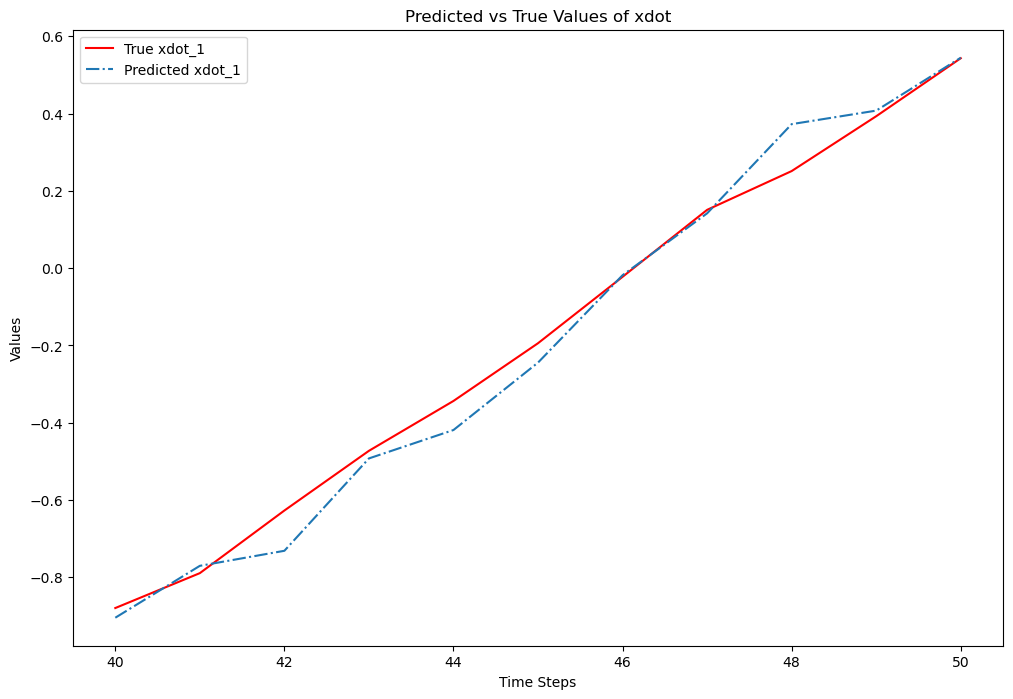

In [30]:
plt.figure(figsize=(12, 8))
start, end = 40, 50
plt.plot(time_steps[start:end+1], all_targets[start:end+1, 1], 'r', label=f'True xdot_{1}')
plt.plot(time_steps[start:end+1], all_predictions[start:end+1, 1], label=f'Predicted xdot_{1}', linestyle='-.')

plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Predicted vs True Values of xdot')
plt.legend()
plt.show()

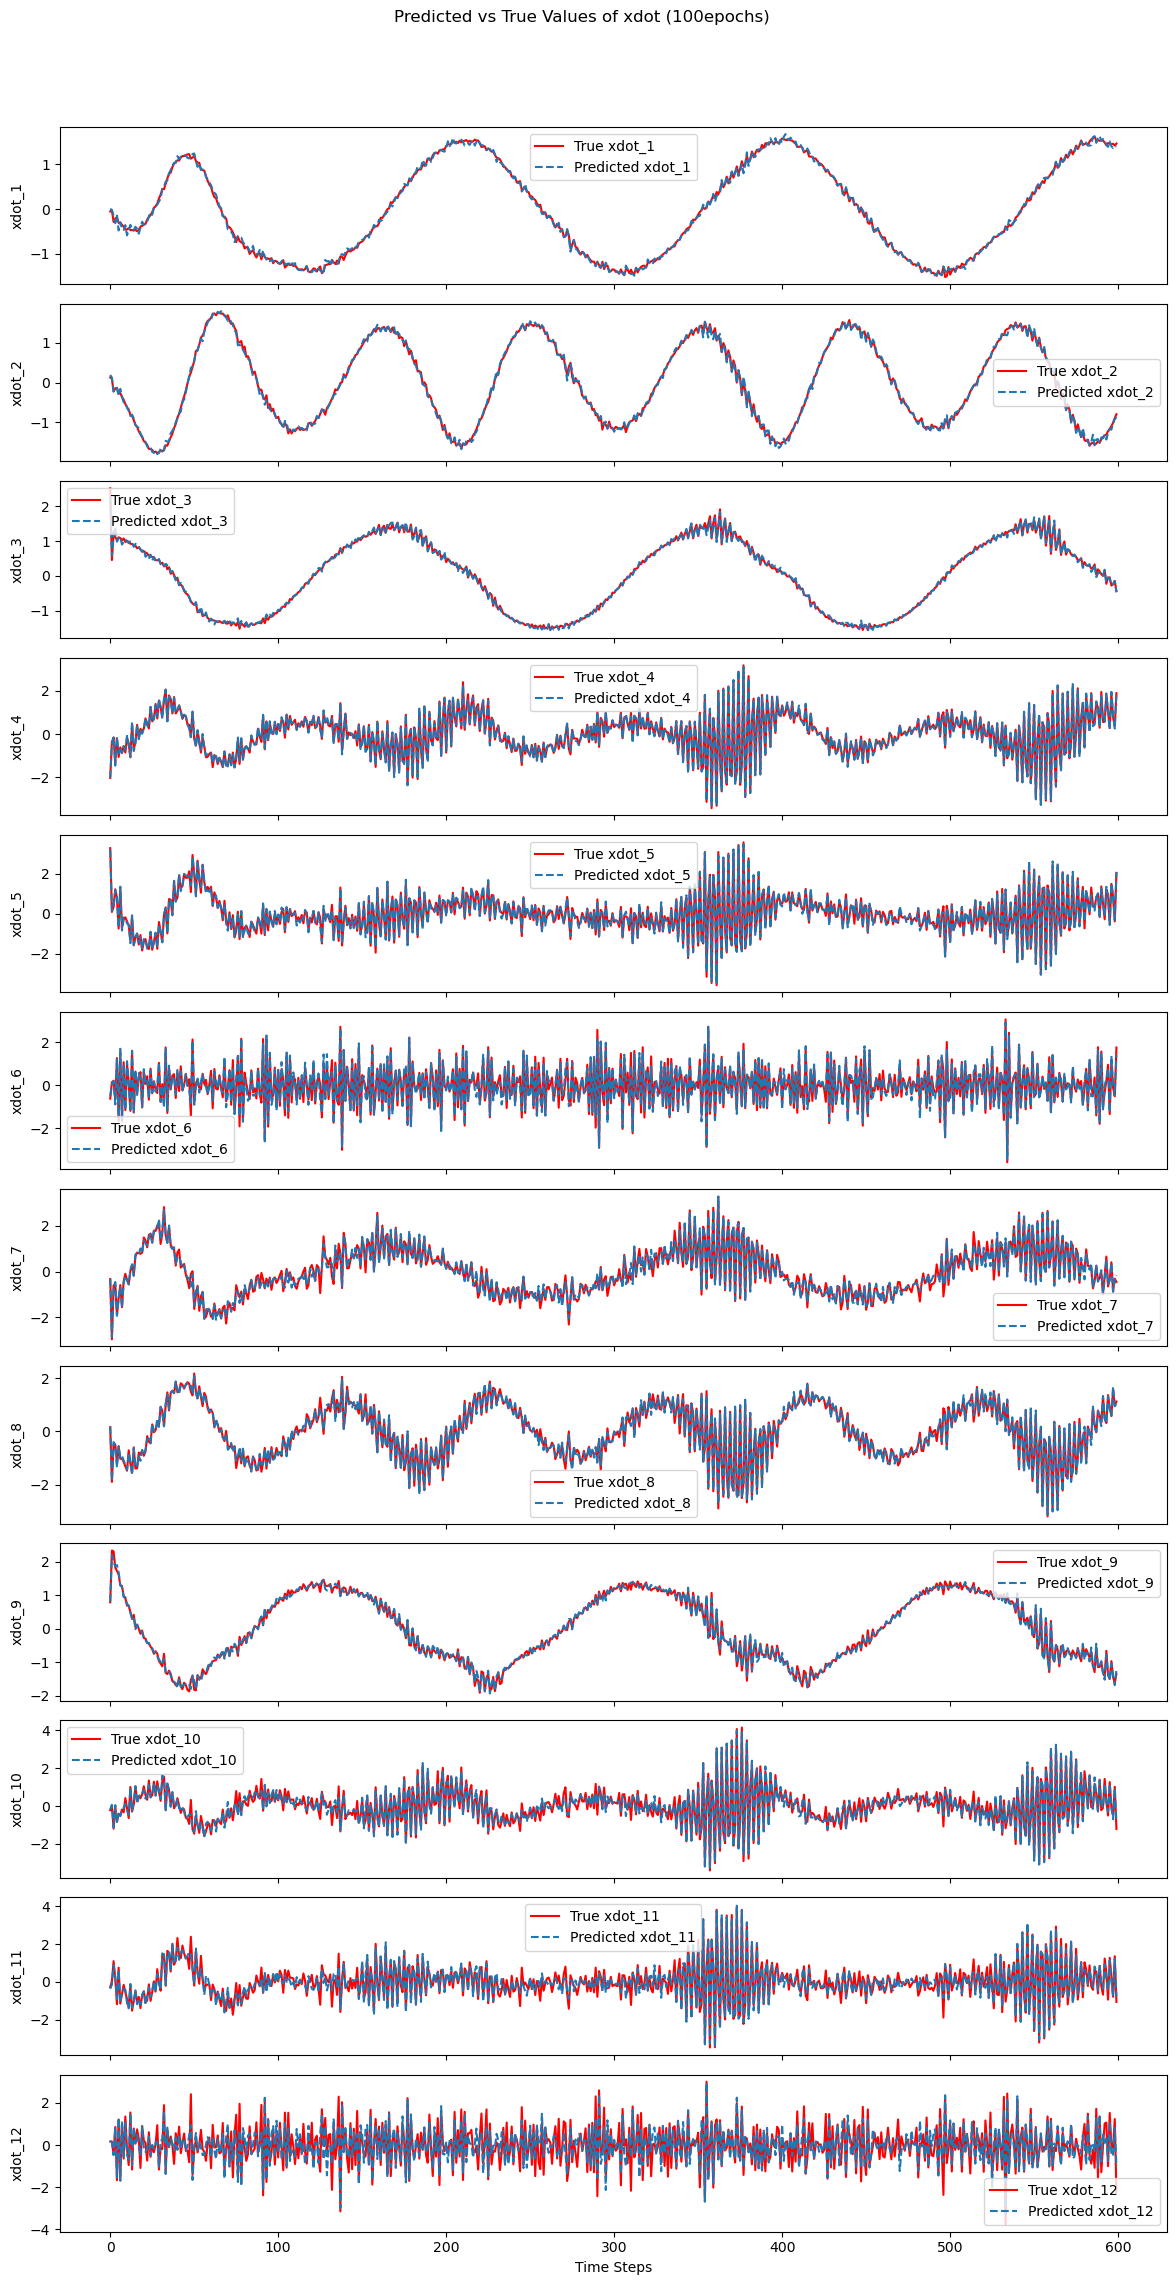

In [33]:
fig, axes = plt.subplots(num_outputs, 1, figsize=(12, 2 * num_outputs), sharex=True)
fig.suptitle('Predicted vs True Values of xdot (100epochs)')

# Plot each component on an individual subplot
for i in range(num_outputs):
    axes[i].plot(time_steps, all_targets[:, i],'r', label=f'True xdot_{i+1}')
    axes[i].plot(time_steps, all_predictions[:, i], label=f'Predicted xdot_{i+1}', linestyle='--')
    axes[i].set_ylabel(f'xdot_{i+1}')
    axes[i].legend()

# Set common x-axis label
axes[-1].set_xlabel('Time Steps')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

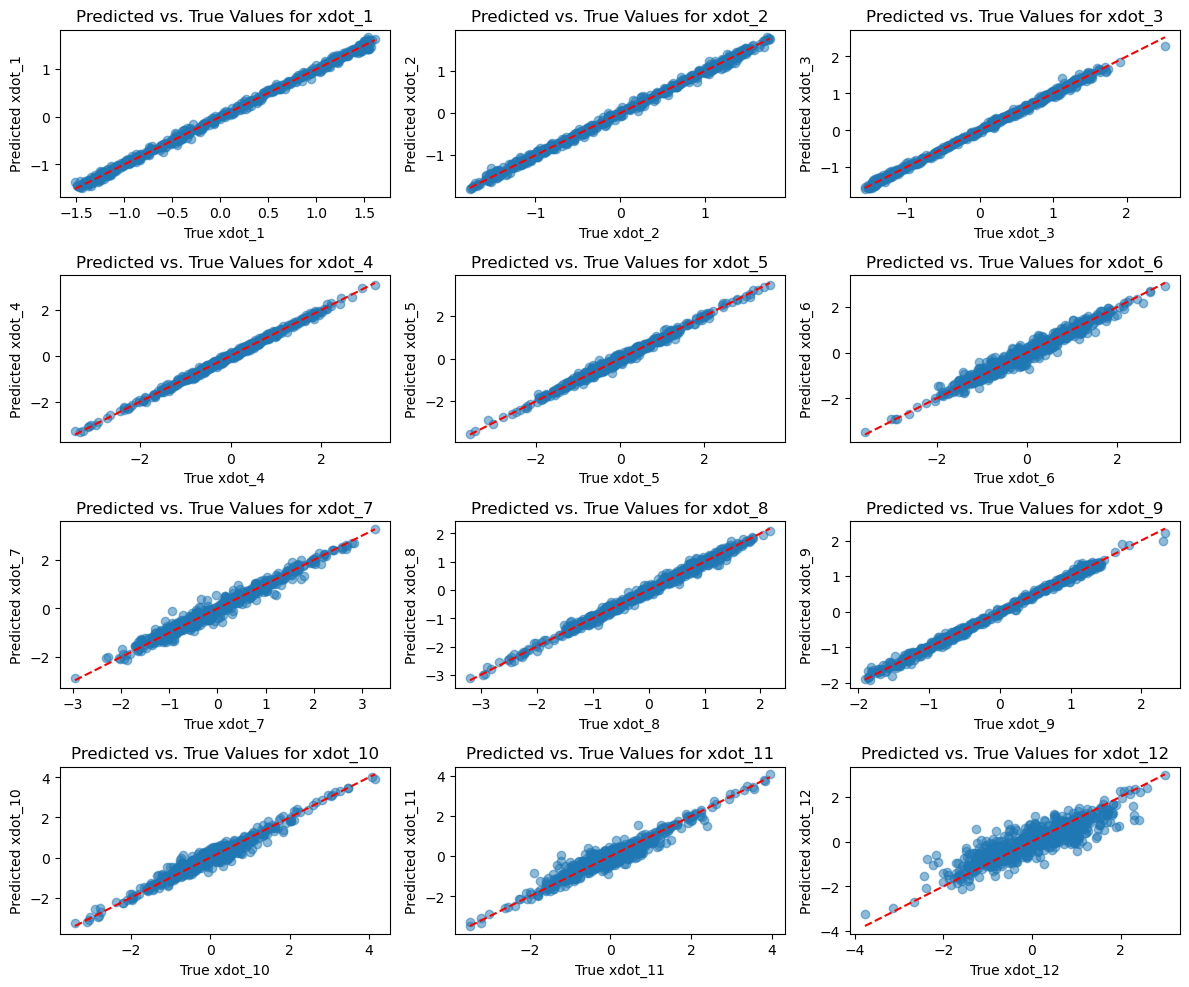

In [32]:
plt.figure(figsize=(12, 12))
for i in range(num_outputs):
    plt.subplot(num_outputs // 3 + 1, 3, i + 1)
    plt.scatter(all_targets[:, i], all_predictions[:, i], alpha=0.5)
    plt.plot([all_targets[:, i].min(), all_targets[:, i].max()],
             [all_targets[:, i].min(), all_targets[:, i].max()], 'r--')
    plt.xlabel(f'True xdot_{i+1}')
    plt.ylabel(f'Predicted xdot_{i+1}')
    plt.title(f'Predicted vs. True Values for xdot_{i+1}')
plt.tight_layout()
plt.show()